# H2O.ai XGBoost GPU Benchmarks

In this notebook, we benchmark the latest version of [XGBoost](https://github.com/h2oai/xgboost), the well-known Kaggle-winning gradient boosting algorithm, and in particular, the [XGBoost GPU plugin](https://github.com/h2oai/xgboost/blob/master/plugin/updater_gpu/README.md).

In [1]:
## First time only: install xgboost and H2O, and restart the kernel afterwards (modify if needed)
if False:
    ## Build XGBoost from source and install its Python module
    import os
    os.system("rm -rf tmp && mkdir -p tmp && cd tmp && git clone https://github.com/h2oai/xgboost --recursive && cd xgboost && mkdir build && cd build && cmake .. -DPLUGIN_UPDATER_GPU=ON -DCUB_DIRECTORY=../cub -DCUDA_NVCC_FLAGS=\"--expt-extended-lambda -arch=sm_30\" && make -j; make; cd ../python-package && python setup.py install")

    ## Download and install H2O and its Python module
    os.system("cd tmp && wget http://h2o-release.s3.amazonaws.com/h2o/rel-vajda/1/h2o-3.10.5.1.zip && unzip h2o-3.10.5.1.zip")
    os.system("python -m pip install h2o-3.10.5.1/python/h2o-3.10.5.1-py2.py3-none-any.whl --upgrade")
    
    ## restart the kernel!

In [2]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
from sklearn import metrics

In [3]:
path = "/opt/higgs_head_2M.csv"
if not os.path.exists(path):
    os.system("cd /opt/ && wget https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/higgs_head_2M.csv")
num_class = 2
num_round = 100
learn_rate = 0.02
max_depth = 10

## Parse data into a Pandas Frame
df = pd.read_csv(path, header=None)

In [4]:
df_target = df.iloc[:,0]
df.drop(df.iloc[:,0], axis=1, inplace=True)
cols = df.columns.values
df.shape

(2000000, 27)

In [5]:
train = df

In [6]:
train_target = df_target

In [7]:
print(train.shape)

(2000000, 27)


In [8]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                80
On-line CPU(s) list:   0-79
Thread(s) per core:    2
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               2201.000
CPU max MHz:           2201.0000
CPU min MHz:           1200.0000
BogoMIPS:              4391.41
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              51200K
NUMA node0 CPU(s):     0-19,40-59
NUMA node1 CPU(s):     20-39,60-79
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtop

In [9]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       528278376 kB


In [10]:
!nvidia-smi -L

GPU 0: Tesla P100-SXM2-16GB (UUID: GPU-77864ed9-e817-3463-e5be-bf4c4c563a4c)
GPU 1: Tesla P100-SXM2-16GB (UUID: GPU-e8ece262-f677-038f-5b40-6cc86f978487)
GPU 2: Tesla P100-SXM2-16GB (UUID: GPU-7d996bf3-876b-1439-e447-ec8fb235fd98)
GPU 3: Tesla P100-SXM2-16GB (UUID: GPU-151287c0-bb97-6f82-fedb-a88273ee5447)
GPU 4: Tesla P100-SXM2-16GB (UUID: GPU-99c5cdb5-54b9-ccd2-eb51-a32850d37ebf)
GPU 5: Tesla P100-SXM2-16GB (UUID: GPU-d2d22332-f462-061e-606a-3d6a5ea89848)
GPU 6: Tesla P100-SXM2-16GB (UUID: GPU-5cc8b757-ee04-3bbb-5866-1f9f8c404a54)
GPU 7: Tesla P100-SXM2-16GB (UUID: GPU-3016922d-1da7-46cd-17f3-cb6b3ab17bc3)


In [11]:
def runXGBoost(param):
    have_updater = "updater" in param.keys()
    label = "XGBoost " \
        + ("GPU hist" if have_updater and param["updater"]=="grow_gpu_hist" else "GPU exact" if have_updater and param["updater"]=="grow_gpu" else "CPU") \
        + " " + (param["tree_method"] if "updater" not in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
    
    t_start = time.time()
    dtrain = xgb.DMatrix(train.values, label = train_target.values, feature_names=[str(c) for c in cols])
    tt = time.time() - t_start
    print("Time to create DMatrix (sec): ", tt)
    dmatrix_times.append(tt)
    
    t_start = time.time()
    bst = xgb.train(param, dtrain, num_round)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    train_times.append(tt)

    t_start = time.time()
    preds = bst.predict(dtrain)
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    score_times.append(tt)

    labels = dtrain.get_label()
    auc = metrics.roc_auc_score(labels, preds)
    print("Training AUC:", auc)
    valid_aucs.append(auc)
    plot_labels.append(label)
    
    fs = bst.get_fscore()
    
    # Optional: Uncomment to show variable importance
    #varimp = pd.DataFrame({'Importance': list(fs.values()), 'Feature': list(fs.keys())})
    #varimp.sort_values(by = 'Importance', inplace = True, ascending = False)
    #varimp.head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [12]:
valid_aucs = []
dmatrix_times = []
train_times = []
score_times = []
plot_labels = []

In [13]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU exact
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.1742866039276123
Time to train (sec):  159.56165313720703
Time to predict (sec):  0.009652853012084961
Training AUC: 0.814825032969


In [14]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"approx"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU approx
objective reg:logistic
max_depth 10
eta 0.02
tree_method approx
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.2854974269866943
Time to train (sec):  1495.3452472686768
Time to predict (sec):  0.009785652160644531
Training AUC: 0.812860299622


In [15]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU hist
objective reg:logistic
max_depth 10
eta 0.02
tree_method hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.2840948104858398
Time to train (sec):  1990.6603572368622
Time to predict (sec):  0.017139434814453125
Training AUC: 0.813941675296


In [16]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU exact 
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
updater grow_gpu
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.3545997142791748
Time to train (sec):  60.927485942840576
Time to predict (sec):  0.017434358596801758
Training AUC: 0.813104557724


In [17]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "n_gpus":1
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
updater grow_gpu_hist
n_gpus 1
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.2842013835906982
Time to train (sec):  5.168807029724121
Time to predict (sec):  0.006921529769897461
Training AUC: 0.813031311037


In [18]:
data = pd.DataFrame({'algorithm'  :plot_labels,
                     'dmatrix time':dmatrix_times,
                     'training time':train_times,
                     'scoring time':score_times,
                     'training AUC' :valid_aucs}).sort_values(by="training time")
data

,algorithm,dmatrix time,scoring time,training AUC,training time
4,XGBoost GPU hist,1.284201,0.006922,0.813031,5.168807
3,XGBoost GPU exact,1.354600,0.017434,0.813105,60.927486
0,XGBoost CPU exact,1.174287,0.009653,0.814825,159.561653
1,XGBoost CPU approx,1.285497,0.009786,0.812860,1495.345247
2,XGBoost CPU hist,1.284095,0.017139,0.813942,1990.660357


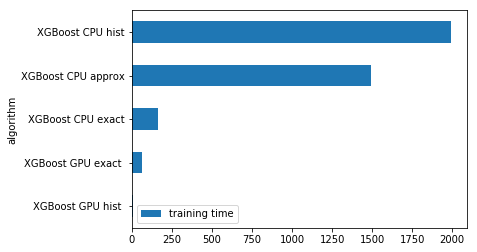

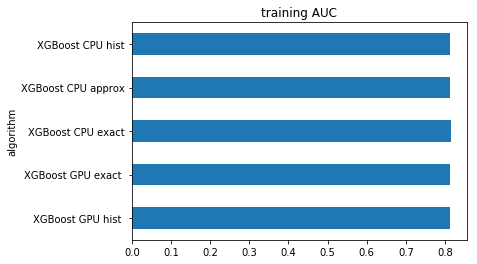

In [19]:
data.plot(label="training time",kind='barh',x='algorithm',y='training time')
data.plot(title="training AUC",kind='barh',x='algorithm',y='training AUC',legend=False)

## Now call XGBoost from H2O

In [20]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
h2o.init()

t_start = time.time()
df_hex = h2o.import_file(path)
print("Time to parse by H2O (sec): ", time.time() - t_start)

trainhex = df_hex
trainhex[0] = (trainhex[0]).asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjxqvjov6
  JVM stdout: /tmp/tmpjxqvjov6/h2o_nimbix_started_from_python.out
  JVM stderr: /tmp/tmpjxqvjov6/h2o_nimbix_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.10.5.1
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_nimbix_3nu9n1
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,64
H2O cluster allowed cores:,64
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
Time to parse by H2O (sec):  4.090161085128784


In [21]:
def runH2OXGBoost(param):
    label = "H2O XGBoost " \
    + ("GPU" if "backend" in param.keys() and "gpu"==param["backend"] else "CPU") \
    + (" " + param["tree_method"] if "tree_method" in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
        
    t_start = time.time()
    model = H2OXGBoostEstimator(**param)
    model.train(x = list(range(1,trainhex.shape[1])), y = 0, training_frame = trainhex)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    h2o_train_times.append(tt)

    t_start = time.time()
    preds = model.predict(trainhex)[:,2]
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    h2o_score_times.append(tt)

    preds = h2o.as_list(preds)
    labels = train_target.values
    auc = metrics.roc_auc_score(labels, preds)
    print("Training AUC:", auc)

    h2o_valid_aucs.append(auc)
    h2o_plot_labels.append(label)
    
    #pd.DataFrame(model.varimp(),columns=["Feature","","Importance",""]).head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [22]:
h2o_valid_aucs = []
h2o_train_times = []
h2o_score_times = []
h2o_plot_labels = []

In [23]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

H2O XGBoost CPU exact
ntrees 100
max_depth 10
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method exact
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  191.8908770084381
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  9.226312637329102
Training AUC: 0.819896987781


In [24]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"approx"
}
runH2OXGBoost(param)

H2O XGBoost CPU approx
ntrees 100
max_depth 10
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method approx
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  375.6521375179291
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  9.216976165771484
Training AUC: 0.818158055647


In [25]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

H2O XGBoost CPU hist
ntrees 100
max_depth 10
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method hist
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  319.5883173942566
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  8.218228101730347
Training AUC: 0.819105186679


In [26]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

H2O XGBoost GPU exact
ntrees 100
max_depth 10
learn_rate 0.02
sample_rate 0.7
col_sample_rate_per_tree 0.9
min_rows 5
seed 12345
score_tree_interval 100
backend gpu
tree_method exact
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  87.38396406173706
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  9.285176277160645
Training AUC: 0.819862038742


In [27]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

H2O XGBoost GPU hist
ntrees 100
max_depth 10
learn_rate 0.02
sample_rate 0.7
col_sample_rate_per_tree 0.9
min_rows 5
seed 12345
score_tree_interval 100
backend gpu
tree_method hist
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  18.19245219230652
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  9.251879215240479
Training AUC: 0.819322641703


## H2O GBM (CPU)

In [28]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
param = {
      "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
}

t_start = time.time()
model = H2OGradientBoostingEstimator(**param)
model.train(x = list(range(1,trainhex.shape[1])), y = 0, training_frame = trainhex)
tt = time.time() - t_start
print("Time to train (sec): ", tt)
h2o_train_times.append(tt)

t_start = time.time()
preds = model.predict(trainhex)[:,2]
tt = time.time() - t_start
print("Time to predict (sec): ", tt)
h2o_score_times.append(tt)

preds = h2o.as_list(preds)
labels = train_target.values
auc = metrics.roc_auc_score(labels, preds)
print("AUC:", auc)

h2o_valid_aucs.append(auc)
h2o_plot_labels.append("H2O GBM CPU")

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  36.68911123275757
gbm prediction progress: |████████████████████████████████████████████████| 100%
Time to predict (sec):  2.4666004180908203
AUC: 0.818376121653


In [29]:
data = pd.DataFrame({'algorithm'  :h2o_plot_labels,
                     'training time':h2o_train_times,
                     'scoring time':h2o_score_times,
                     'training AUC' :h2o_valid_aucs}).sort_values(by="training time")
data

,algorithm,scoring time,training AUC,training time
4,H2O XGBoost GPU hist,9.251879,0.819323,18.192452
5,H2O GBM CPU,2.466600,0.818376,36.689111
3,H2O XGBoost GPU exact,9.285176,0.819862,87.383964
0,H2O XGBoost CPU exact,9.226313,0.819897,191.890877
2,H2O XGBoost CPU hist,8.218228,0.819105,319.588317
1,H2O XGBoost CPU approx,9.216976,0.818158,375.652138


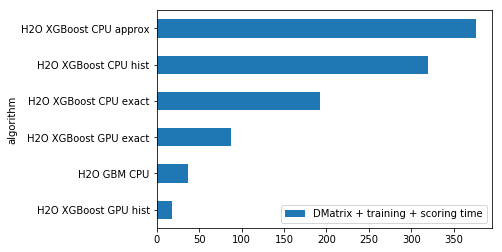

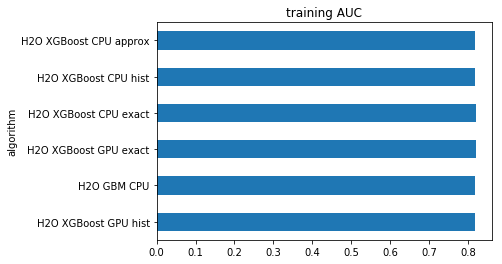

In [31]:
data.plot(label="DMatrix + training + scoring time",kind='barh',x='algorithm',y='training time')
data.plot(title="training AUC",kind='barh',x='algorithm',y='training AUC',legend=False)

### Summary: Fastest GPU algorithm (XGBoost histogram) takes 5s, fastest CPU algorithm (H2O) takes 50s

##### Note: H2O's XGBoost integration has some internal overhead still (DMatrix creation is single-threaded, and H2O scores the model at the end of training, and some parameters have different default values, hence the slightly slower training speed and slightly higher training accuracy) - this doesn't affect the summary conclusion